In [2]:
import pandas as pd
import math as mt
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#copy dispersion function:
def dispersion(ClusterData, x = 'x_coord', y = 'y_coord'):
    '''
    This function calculates the dispersion of a cluster from a pandas dataframe giving the x and y coordinates of .
    The dispersion is defined as the standard deviation of the distance between all possible crater pairs.
    This method gives meaningul results for clusters with more than 3 craters in a cluster.
    It is using the radius of Mars to convert from lat/lon data to metres.

    :param ClusterData: Dataframe containing all craters in clusters
    :type ClusterData: pandas dataframe
    :param x: column name giving the longitude, defaults to 'x_coord'
    :type x: str
    :param y: column name giving the latitude, defaults to 'y_coord'
    :type y: str
    '''
    Rmars = 3390000 #radius of Mars in metres
    #x and y are the names of the column in ClusterData denoting the x and y coordinates respectively
    #Assumes that x and y are in degrees still!
    df = ClusterData.copy() #create work copy of database
    coord_array = np.array(df[[x, y]]) #create array of xy coordinates for craters in cluster
    sep_list = []
    for n in range(0, len(coord_array)): #iterating over all craters for separation calculation
        for m in range(n+1, len(coord_array)): #calculating seperation ((x2-x1)**2 + (y2 - y1)**2)**0.5 for all combinations
            dx= (coord_array[m,0] - coord_array[n,0]) *Rmars*(np.pi/180)*mt.sin(mt.radians(90 - ((coord_array[m,0]+ coord_array[n,0])/2))) #converting to metres based xy coordinates
            dy = (coord_array[m,1] - coord_array[n,1]) *Rmars*(np.pi/180)
            sep = (dx**2+ dy**2)**0.5
            sep_list.append(sep) #adding all separations to list
    dispersion = np.std(sep_list) #calculating dispersion as standard deviation
    sep_array = np.array(sep_list)
    return dispersion, sep_array

In [4]:
#import crater data:
df = pd.read_excel('DataTables/MainSheet.xlsx', index_col = [0,1])
df_parameters = pd.read_excel('C:/Users/jae4518/OneDrive - Imperial College London/HiRise_Images_Clusters/ClustersDataSheet/NewClustersParameters.xlsx', index_col = 0)
df_observations = pd.read_excel('C:/Users/jae4518/OneDrive - Imperial College London/HiRise_Images_Clusters/Analysis/NewClustersObservations.xlsx', index_col = 0)

In [75]:
#run the dispersion on all clusters and create a Multiindex of all separations for each cluster
df_separations = pd.DataFrame()
for ID, df_new in df.groupby(level = 0):
    if len(df_new.index)>3:
        disp, sep_array = dispersion(df_new)
        ID_list = len(sep_array)*[ID]
        index = [i for i in range(len(sep_array))]
        df_sep = pd.DataFrame(data = {'HiRise_ID':ID_list})
        df_sep['pair'] = index
        df_sep['Separation(m)'] = sep_array
        df_sep['Normalized Separation'] = sep_array/np.mean(sep_array)
        df_sep.set_index(['HiRise_ID', 'pair'], inplace = True)
        df_separations = pd.concat([df_separations, df_sep])

In [83]:
#adding the mean, median, mode, lowest quartile and lowest decentile to the parameters list
mean_dict = {}
median_dict = {}
mode_dict = {}
quart_dict = {}
cent_dict = {}
for ID, df_new in df_separations.groupby(level = 0):
    mean_dict[ID] = df_new['Normalized Separation'].mean()
    median_dict[ID] = df_new['Normalized Separation'].median()
    mode_dict[ID] = df_new['Normalized Separation'].mode()
    cent_dict[ID], quart_dict[ID] = df_new['Normalized Separation'].quantile([0.1, 0.25])
df_parameters['Normalized Separation mean'] = df_parameters['HiRise_ID'].map(mean_dict)
df_parameters['Normalized Separation median'] = df_parameters['HiRise_ID'].map(median_dict)
df_parameters['Normalized Separation mode'] = df_parameters['HiRise_ID'].map(mode_dict)
df_parameters['Normalized Separation lowest decentile'] = df_parameters['HiRise_ID'].map(cent_dict)
df_parameters['Normalized Separation lowest quartile'] = df_parameters['HiRise_ID'].map(quart_dict)
print(df_parameters.head())

         HiRise_ID  Number_Craters   d_eff  d_max  central_latitude  \
0  ESP_046463_2160             324  17.640   9.14             35.86   
1  PSP_007009_1905             181  20.780  12.90             10.39   
2  ESP_051357_1880             157  29.600  16.50              7.80   
3  ESP_055581_1985              92   8.190   3.99             18.52   
4  ESP_047175_1955              68   7.943   4.19             15.56   

   central_longitude  Dispersion(m)   F_value  N>D/2          R1  ...  \
0            -129.13      92.281688  0.030581     10  177.294324  ...   
1            -109.77     325.046990  0.033149      6  250.652079  ...   
2             176.45      62.331206  0.038217      6  127.423434  ...   
3              52.31     165.519829  0.186813     17  266.375047  ...   
4            -125.91      64.146956  0.191176     13   46.017558  ...   

   Separation median (m)                                Separation mode (m)  \
0             140.232333  0          1.263719
1        

In [7]:
df_parameters.to_excel('DataTables/NewClusterParameters.xlsx') #save to the repository

In [84]:
subclustered = df_observations['HiRise_ID'].loc[df_observations['Subclustering?'] == True].tolist()
sub = {}
for element in subclustered:
    sub[element] = True
no_subclustered = df_observations['HiRise_ID'].loc[df_observations['Subclustering?'] == False].tolist()
for element in no_subclustered:
    sub[element] = False

In [85]:
df_parameters['Observed Subclustering?'] = df_parameters['HiRise_ID'].map(sub)
df_parameters.columns.values

array(['HiRise_ID', 'Number_Craters', 'd_eff', 'd_max',
       'central_latitude', 'central_longitude', 'Dispersion(m)',
       'F_value', 'N>D/2', 'R1', 'R2', 'Impact Angle',
       'Separation mean (m)', 'Separation median (m)',
       'Separation mode (m)', 'Separation lowest decentile (m)',
       'Separation lowest quartile (m)', 'Observed Subclustering?',
       'Normalized Separation mean', 'Normalized Separation median',
       'Normalized Separation mode',
       'Normalized Separation lowest decentile',
       'Normalized Separation lowest quartile'], dtype=object)

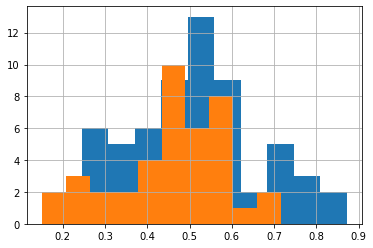

In [94]:
for ID, df_new in df_parameters.groupby(by = df_parameters['Observed Subclustering?']):
    df_new['Normalized Separation lowest quartile'].hist()